Importing All the essential libraries and checking for errors

In [1]:
import numpy as np
import torch.utils.data
import torch
import torch.optim as opt
import torch.nn as nn
import os.path
import struct
from array import array
import matplotlib.pyplot as plt

Creating a Loader class to load the MNIST dataset

In [2]:
class LoadData:
    def __init__(self, training_image_path, training_label_path, test_image_path, test_image_label):
        self.Training_images_path = training_image_path
        self.Training_label_path = training_label_path
        self.Test_image_path = test_image_path
        self.Test_image_label = test_image_label
    def GetData(self, data_path, label_path):
        labels = []
        images = []
        with open(label_path, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read()) 
        with open(data_path, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
            for i in range(size):
                images.append([0] * rows * cols)
            for i in range(size):
                img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
                img = img.reshape(28, 28)
                images[i][:] = img
        return images, labels
    def LoadData(self):
        x_train, y_train = self.GetData(self.Training_images_path, self.Training_label_path)
        x_test, y_test = self.GetData(self.Test_image_path, self.Test_image_label)
        return (x_train, y_train), (x_test, y_test)
        
        

A temporary helper function to show the loaded data

In [3]:
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

Loading the data and visualizing it

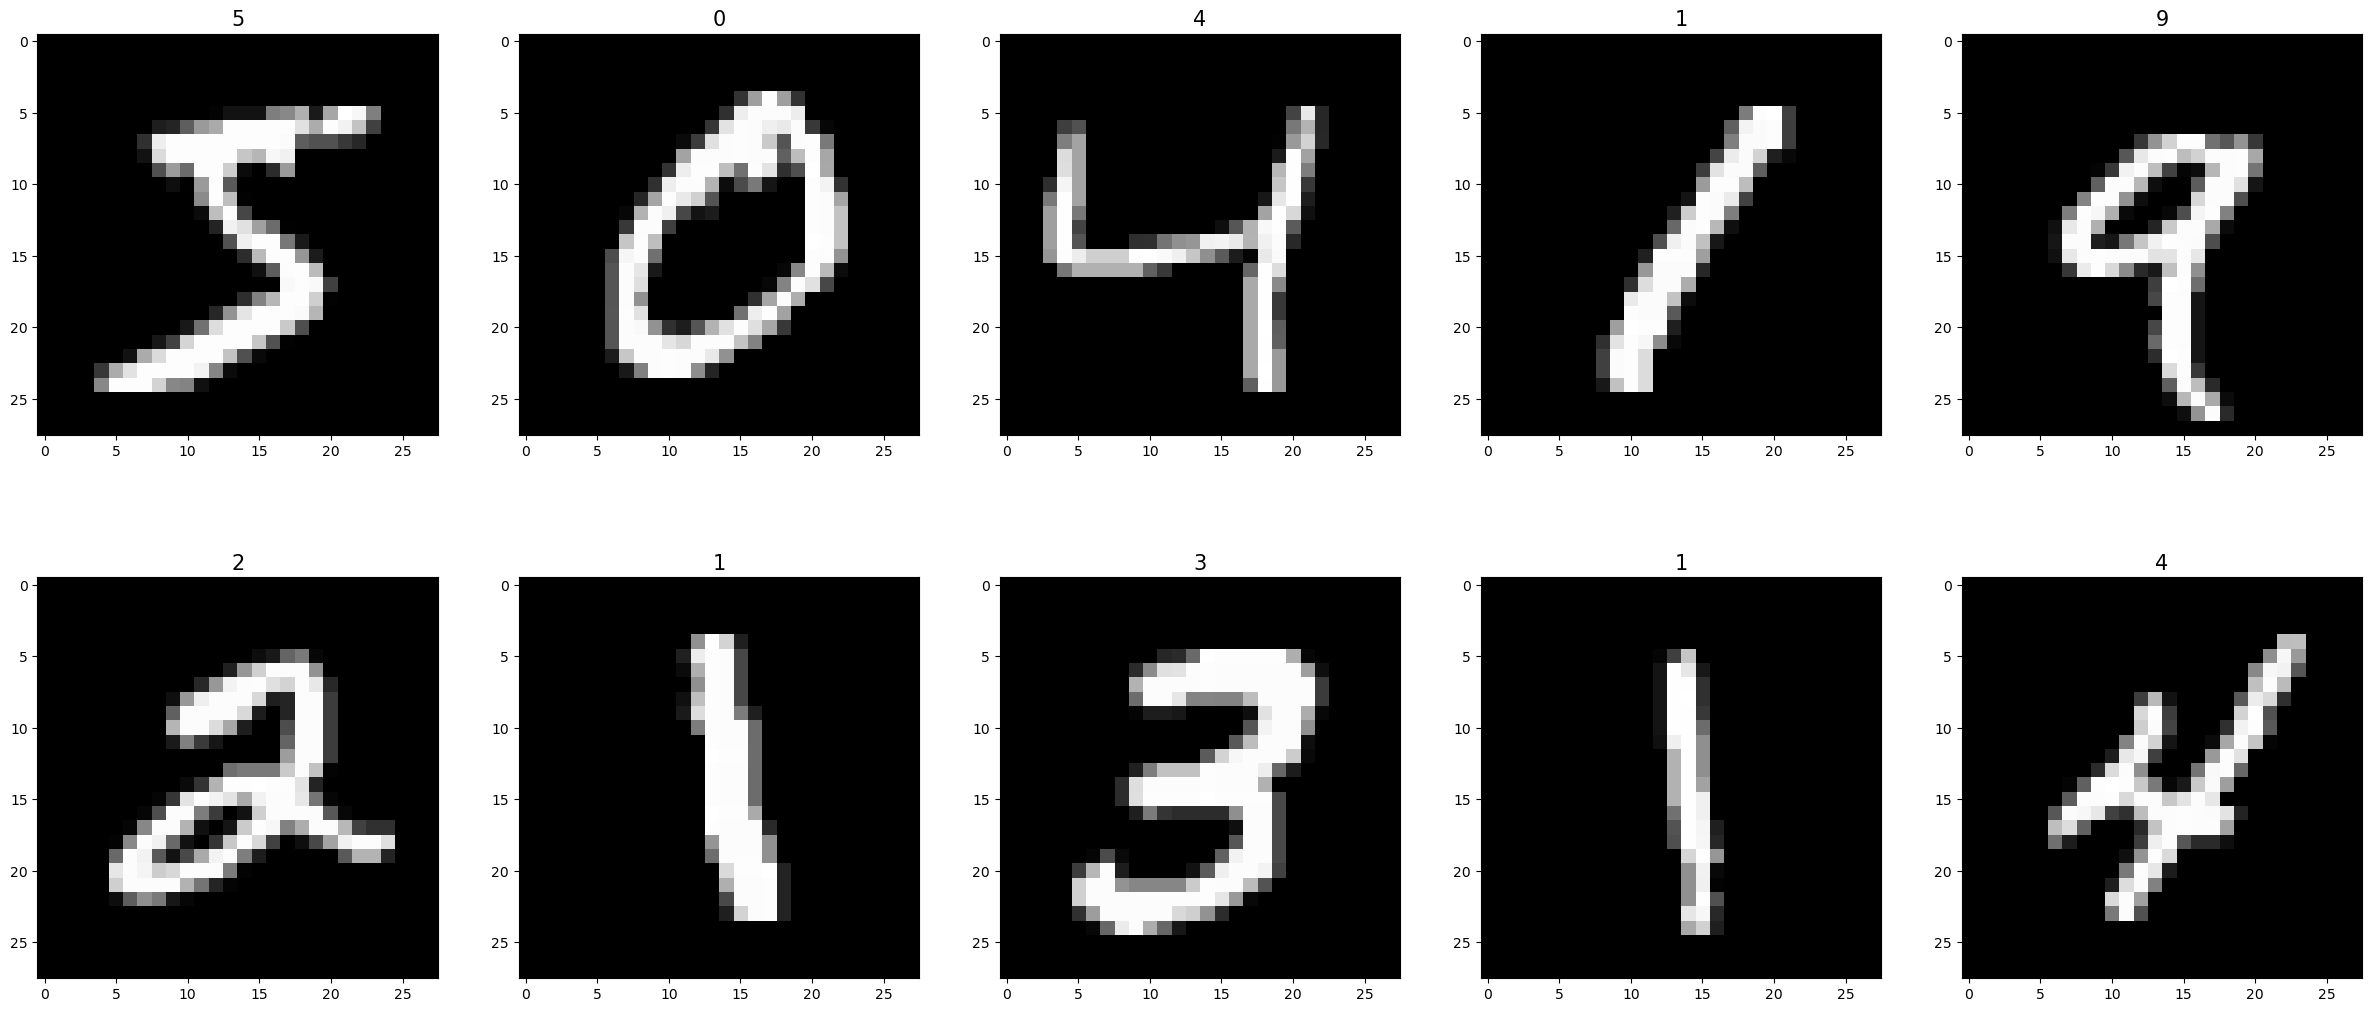

In [4]:
train_data_path = "MNIST/train-images.idx3-ubyte"
train_label_path = "MNIST/train-labels.idx1-ubyte"
test_label_path = "MNIST/t10k-labels.idx1-ubyte"
test_data_path = "MNIST/t10k-images.idx3-ubyte"

Loader = LoadData(train_data_path, train_label_path, test_data_path, test_label_path)
(x_train, y_train), (x_test, y_test) = Loader.LoadData()
show_images(x_train[:10], y_train[:10])

Chaning Data from array to tensors

In [5]:
y_train_temp = []
for i in y_train:
    k = [0.0] * 10
    k[i] = 1
    y_train_temp.append(k)
y_test_temp = []
for i in y_test:
    k = [0.0] * 10
    k[i] = 1
    y_test_temp.append(k)

x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_temp, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_temp, dtype=torch.float32)

C:\Users\Ghanibhuti\AppData\Local\Temp\ipykernel_29888\102969836.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\b\abs_6fueooay2f\croot\pytorch-select_1707342446212\work\torch\csrc\utils\tensor_new.cpp:278.)
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)


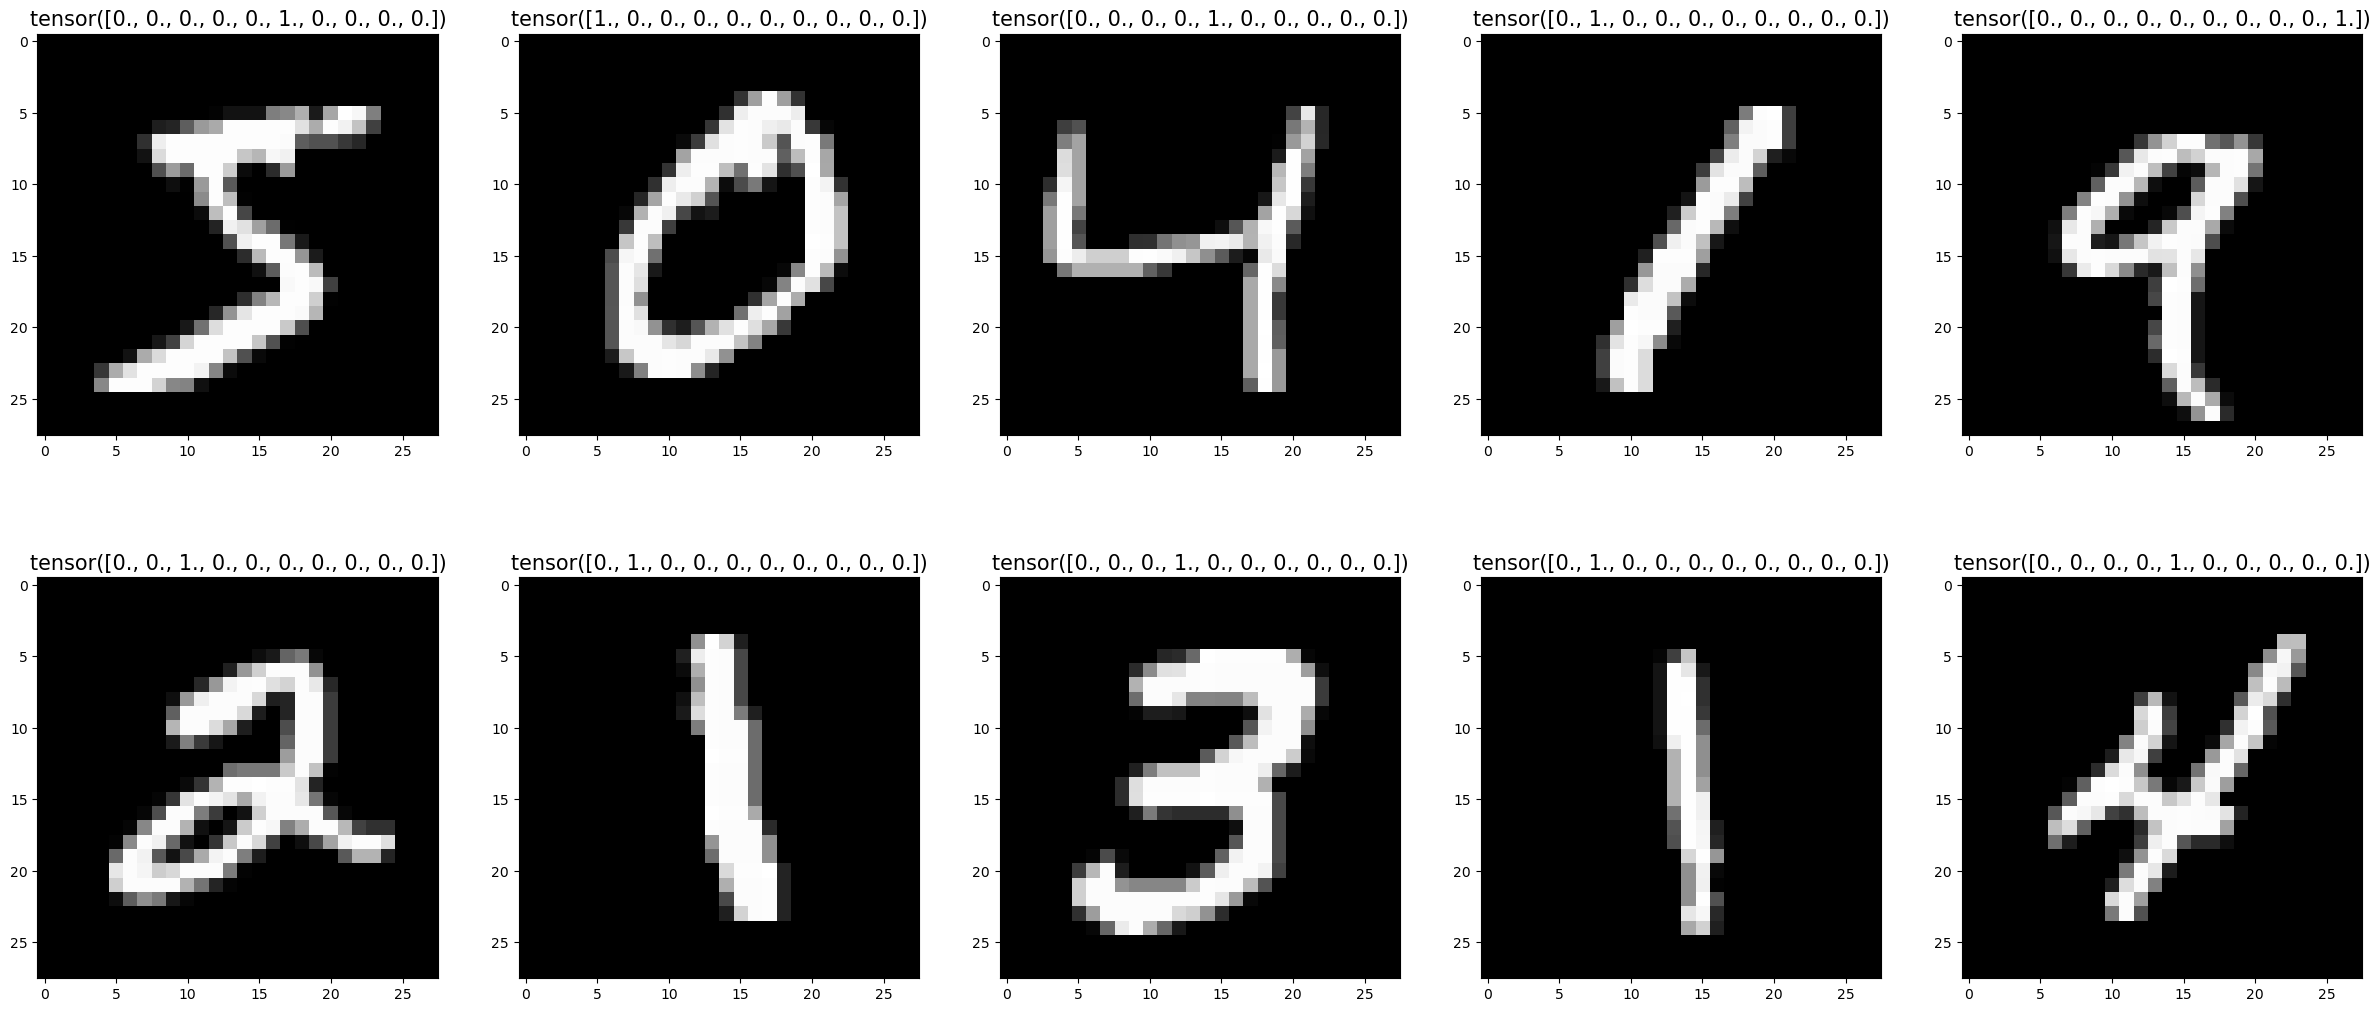

In [6]:
show_images(x_train_tensor[:10], y_train_tensor[:10])

In [41]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.Matrix1 = nn.Linear(28*28, 100)
        self.Matrix2 = nn.Linear(100,50)
        self.Matrix3 = nn.Linear(50,20)
        self.Matrix4 = nn.Linear(20,10)
        self.R = nn.ReLU()
        #self.Flatten = nn.Flatten()
    def forward(self, x):
        x = x.view(-1, 28**2)
        x = self.R(self.Matrix1(x))
        x = self.R(self.Matrix2(x))
        x = self.R(self.Matrix3(x))
        x = self.Matrix4(x)
        return x.squeeze()

In [42]:
class DataStructure:
    def __init__(self, x_train, y_train):
        self.x = x_train
        self.y = y_train
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    def __len__(self):
        return len(self.y)
    

In [43]:
import torch.utils.data as dt
Model = MyModel()
LossFunction = nn.CrossEntropyLoss()
Optimizer = opt.SGD(Model.parameters(), lr=0.01)
_dataset = DataStructure(x_train_tensor, y_train_tensor)
_dataLoader = dt.DataLoader(dataset=_dataset, batch_size=1200)

In [44]:
def TrainModel(model, dt_loader, Loss, Opt,n_epochs=20 ):
    Losses = []
    epochs = []
    model.train()
    for epoch in range(n_epochs):
        print("Epoch : ", epoch, end=" ")
        for i, (x,y) in enumerate(dt_loader):
            Opt.zero_grad()
            l = Loss(model(x), y)
            l.backward()
            Opt.step()
            Losses.append(l.item())
            epochs.append(epoch + i/len(dt_loader))
    return np.array(epochs), np.array(Losses), model
    

In [45]:
Epocs, Losses, Model = TrainModel(Model, _dataLoader, LossFunction, Optimizer, n_epochs=20)

Epoch :  0 Epoch :  1 Epoch :  2 Epoch :  3 Epoch :  4 Epoch :  5 Epoch :  6 Epoch :  7 Epoch :  8 Epoch :  9 Epoch :  10 Epoch :  11 Epoch :  12 Epoch :  13 Epoch :  14 Epoch :  15 Epoch :  16 Epoch :  17 Epoch :  18 Epoch :  19 

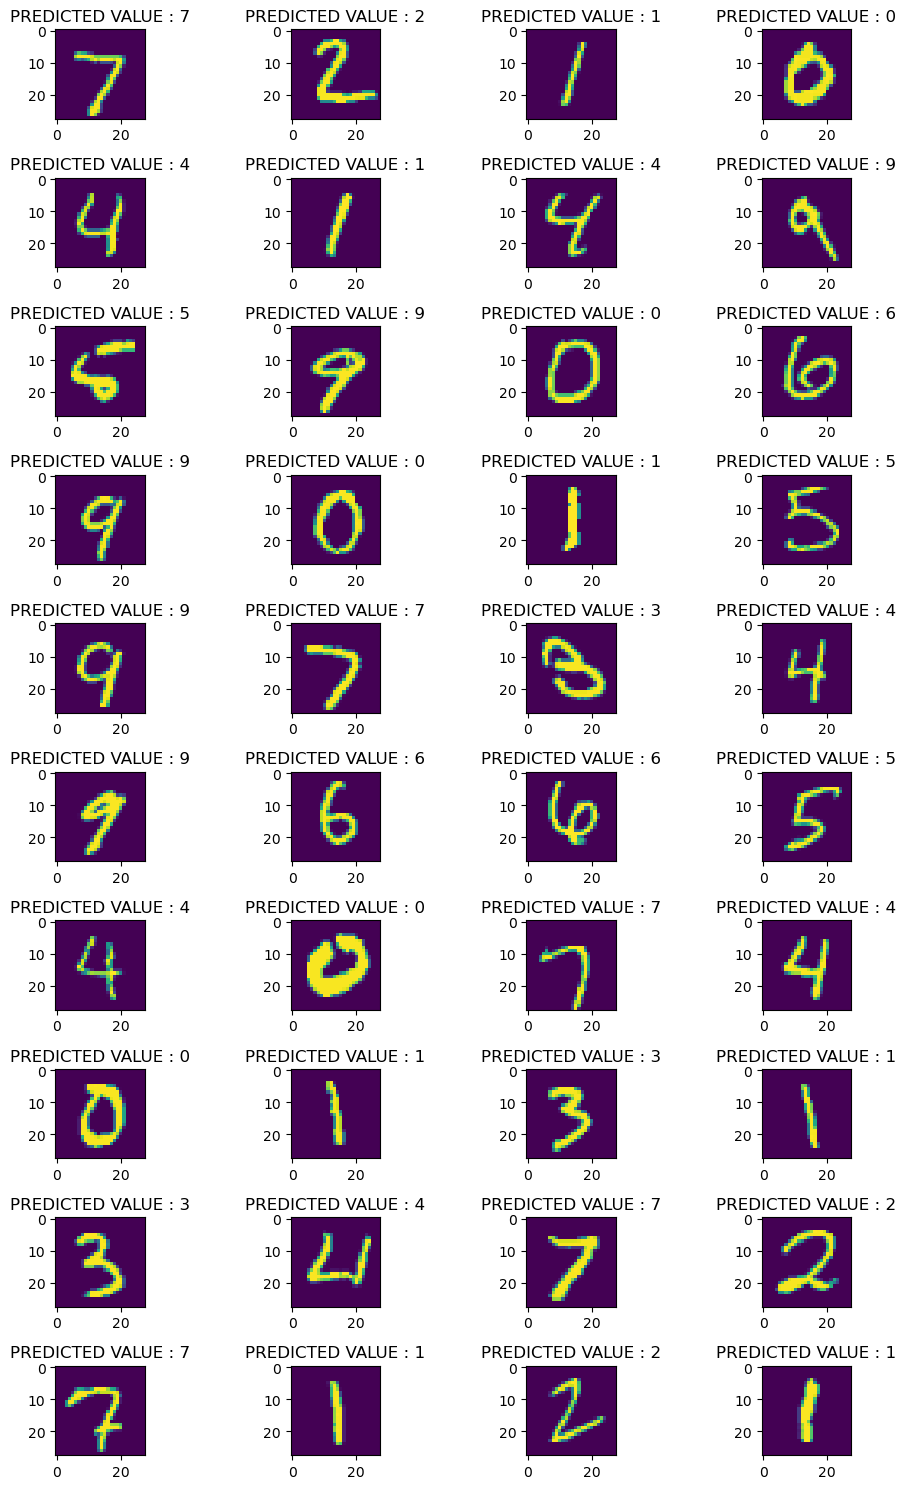

In [46]:
ys = Model(x_test_tensor[:40]).argmax(axis=1)
fig,ax = plt.subplots(10,4, figsize=(10,15))
for i in range(40):
    plt.subplot(10,4, i+1)
    plt.imshow(x_test_tensor[i])
    plt.title(f"PREDICTED VALUE : {ys[i]}")
fig.tight_layout()
plt.show()